# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import pandas as pd

import random
import torch
from collections import deque
import matplotlib.pyplot as plt
from dqn_agent import Agent
from tqdm.notebook import tqdm
import time
import os
os.makedirs('results', exist_ok=True)

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
# env_info = env.reset(train_mode=False)[brain_name] # reset the environment
# state = env_info.vector_observations[0]            # get the current state
# score = 0                                          # initialize the score
# while True:
#     action = np.random.randint(action_size)        # select an action
#     env_info = env.step(action)[brain_name]        # send the action to the environment
#     next_state = env_info.vector_observations[0]   # get the next state
#     reward = env_info.rewards[0]                   # get the reward
#     done = env_info.local_done[0]                  # see if episode has finished
#     score += reward                                # update the score
#     state = next_state                             # roll over the state to next time step
#     if done:                                       # exit loop if episode finished
#         break
    
# print("Score: {}".format(score))

Score: 1.0


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

## 4.1 Train agent
In the following train_agent function, we used $\epsilon$-gready searching algorithm and gradually decrease $\epsilon$ from 1.0 to 0.01. We added the (state, action, reward, next_state, done) to experiences deque as the agent's memory and train the network. We record the 100 episode average score to show the convergence of the deep q network.

In [5]:
def train_agent(agent, env, n_episode=3000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.99, train=True, filename='dqn_model'):
    # train the agent using DeepQ network
    scores = []
    scores_win = deque(maxlen=100)
    eps = eps_start
    brain_name = env.brain_names[0]
    start_time = time.time()
    
    for i in tqdm(range(1, n_episode + 1)):
        env_info = env.reset(train_mode=train)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t): # number of steps before episode ends
            action = agent.act(state, eps if train else 0.0) # decrease eps as episode increases
            env_info = env.step(action)[brain_name] # send action to the env
            reward = env_info.rewards[0]
            next_state = env_info.vector_observations[0]
            done = env_info.local_done[0] # check if game ends
            if train:
                agent.step(state, action, reward, next_state, done)
            score += reward
            state = next_state # roll over the state to next time step
            if done:
                break
        
        scores.append(score)
        scores_win.append(score)
        eps = max(eps_end, eps * eps_decay)
        
        # save model check point
        if i % 1000 == 0:
            torch.save(agent.qnn_local.state_dict(), '%s' % filename)
    
    print('taking %.3f (s) for %s model' % (time.time() - start_time, filename))
    return scores

## 4.2 Initialize the agent and train various DQN networks
Initialize the agent, set randomizaion seed and train the agent using DQN.

### 4.2.1 Train DQN and evaluate its performance

In [6]:
# train DQN without dueling
filename = './results/%s' % 'dqn_model'
agent = Agent(state_size, action_size, seed=0, filename='%s.pth' % filename)
score = train_agent(agent, env, filename='%s.pth' % filename)

No available weight file.



taking 4146.114 (s) for ./results/dqn_model.pth model


In [8]:
# plot the trace of scores
fig = plt.figure(dpi=300)
plt.plot(np.arange(len(score)), score, label='raw_score')
plt.plot(np.arange(len(score))[99:], moving_average(score, 100), label='SMA 100')
plt.ylabel('Score'); plt.xlabel('Episode #'); plt.legend(loc='best');
plt.savefig('%s.png' % filename)
plt.close()

# save smoothed results
pd.DataFrame({'episode' : np.arange(len(score))[99:], 'reward' : moving_average(score, 100)}).to_csv('%s.csv' % filename, index=False)

# evaluate DQN
agent = Agent(state_size=state_size, action_size=action_size, seed=0, filename='%s.pth' % filename)
scores = train_agent(agent, env, n_episode=10, train=False)

# show 10testing episodes and close env
scores, np.mean(scores)

Weight loaded successful from the file: ./results/dqn_model.pth.



taking 298.328 (s) for dqn_model model


([15.0, 15.0, 16.0, 18.0, 16.0, 21.0, 16.0, 20.0, 20.0, 15.0], 17.2)

### 4.2.2 Train double DQN and Evaluate Performance

In [9]:
# train double DQN without dueling
filename = './results/%s' % 'ddqn_model'
agent = Agent(state_size, action_size, seed=0, filename='%s.pth' % filename, double=True)
score = train_agent(agent, env, filename='%s.pth' % filename)

No available weight file.



taking 4535.469 (s) for ./results/ddqn_model.pth model


In [10]:
# plot the trace of scores
fig = plt.figure(dpi=300)
plt.plot(np.arange(len(score)), score, label='raw_score')
plt.plot(np.arange(len(score))[99:], moving_average(score, 100), label='SMA 100')
plt.ylabel('Score'); plt.xlabel('Episode #'); plt.legend(loc='best');
plt.savefig('%s.png' % filename)
plt.close()

# save smoothed results
pd.DataFrame({'episode' : np.arange(len(score))[99:], 'reward' : moving_average(score, 100)}).to_csv('%s.csv' % filename, index=False)

# evaluate DDQN
agent = Agent(state_size=state_size, action_size=action_size, seed=0, filename='%s.pth' % filename, double=True)
scores = train_agent(agent, env, n_episode=10, train=False)

# show 10testing episodes and close env
scores, np.mean(scores)

Weight loaded successful from the file: ./results/ddqn_model.pth.



taking 300.401 (s) for dqn_model model


([21.0, 19.0, 20.0, 18.0, 3.0, 12.0, 8.0, 17.0, 20.0, 19.0], 15.7)

### 4.2.3 Train DQN and evaluate its performance with dueling

In [6]:
# train DQN without dueling
filename = './results/%s' % 'dqn_dueling_model'
agent = Agent(state_size, action_size, seed=0, filename='%s.pth' % filename, dueling=True)
score = train_agent(agent, env, filename='%s.pth' % filename)

Weight loaded successful from the file: ./results/dqn_dueling_model.pth.



taking 5343.128 (s) for ./results/dqn_dueling_model.pth model


In [7]:
# plot the trace of scores
fig = plt.figure(dpi=300)
plt.plot(np.arange(len(score)), score, label='raw_score')
plt.plot(np.arange(len(score))[99:], moving_average(score, 100), label='SMA 100')
plt.ylabel('Score'); plt.xlabel('Episode #'); plt.legend(loc='best');
plt.savefig('%s.png' % filename)
plt.close()

# save smoothed results
pd.DataFrame({'episode' : np.arange(len(score))[99:], 'reward' : moving_average(score, 100)}).to_csv('%s.csv' % filename, index=False)

# evaluate DDQN
agent = Agent(state_size=state_size, action_size=action_size, seed=0, filename='%s.pth' % filename, dueling=True)
scores = train_agent(agent, env, n_episode=10, train=False)
# show 10testing episodes and close env
scores, np.mean(scores)

Weight loaded successful from the file: ./results/dqn_dueling_model.pth.



taking 298.298 (s) for dqn_model model


([14.0, 23.0, 22.0, 19.0, 23.0, 9.0, 14.0, 18.0, 16.0, 21.0], 17.9)

### 4.2.4 Train double DQN with dueling and Evaluate Performance

In [7]:
# train double DQN without dueling
filename = './results/%s' % 'ddqn_dueling_model'
agent = Agent(state_size, action_size, seed=0, filename='%s.pth' % filename, double=True, dueling=True)
score = train_agent(agent, env, filename='%s.pth' % filename)

Weight loaded successful from the file: ./results/ddqn_dueling_model.pth.



taking 5536.724 (s) for ./results/ddqn_dueling_model.pth model


In [8]:
# plot the trace of scores
fig = plt.figure(dpi=300)
plt.plot(np.arange(len(score)), score, label='raw_score')
plt.plot(np.arange(len(score))[99:], moving_average(score, 100), label='SMA 100')
plt.ylabel('Score'); plt.xlabel('Episode #'); plt.legend(loc='best');
plt.savefig('%s.png' % filename)
plt.close()

# save smoothed results
pd.DataFrame({'episode' : np.arange(len(score))[99:], 'reward' : moving_average(score, 100)}).to_csv('%s.csv' % filename, index=False)

# evaluate DDQN with dueling
agent = Agent(state_size=state_size, action_size=action_size, seed=0, filename='%s.pth' % filename, double=True, dueling=True)
scores = train_agent(agent, env, n_episode=10, train=False)
# show 10testing episodes and close env
scores, np.mean(scores)

Weight loaded successful from the file: ./results/ddqn_dueling_model.pth.



taking 299.160 (s) for dqn_model model


([19.0, 18.0, 13.0, 20.0, 21.0, 14.0, 20.0, 23.0, 0.0, 5.0], 15.3)

# Compare the performance of four methods

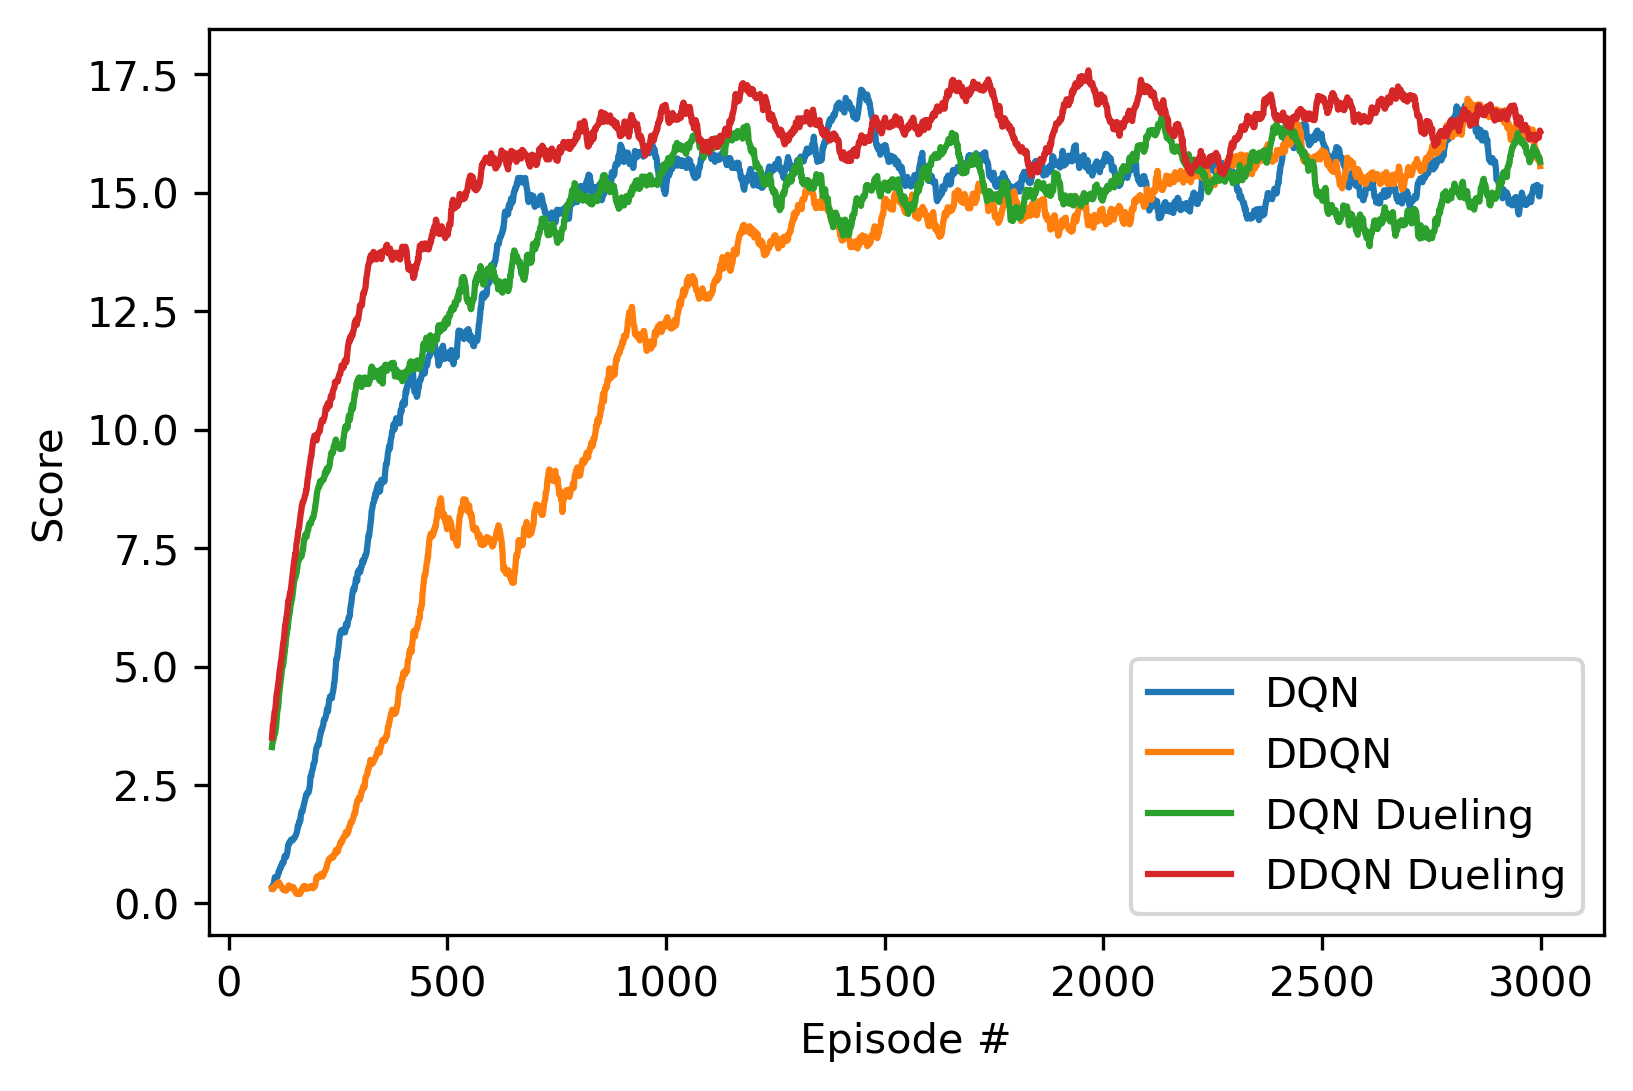

In [5]:
dqn = pd.read_csv('./results/dqn_model.csv')
dqn_dueling = pd.read_csv('./results/dqn_dueling_model.csv')
ddqn = pd.read_csv('./results/ddqn_model.csv')
ddqn_dueling = pd.read_csv('./results/ddqn_dueling_model.csv')

fig = plt.figure(dpi=300)
plt.plot(dqn['episode'], dqn['reward'], label='DQN')
plt.plot(ddqn['episode'], ddqn['reward'], label='DDQN')
plt.plot(dqn_dueling['episode'], dqn_dueling['reward'], label='DQN Dueling')
plt.plot(ddqn_dueling['episode'], ddqn_dueling['reward'], label='DDQN Dueling')
plt.ylabel('Score'); plt.xlabel('Episode #'); plt.legend(loc='best');
plt.savefig('%s.png' % './results/compare')
# plt.close()